In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import re
import io
import requests
import csv

from math import radians, sin, cos, acos, log, pi, tan, asin,sqrt
from decimal import Decimal
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON
from ast import literal_eval
from scipy import stats

In [0]:
#from google.colab import drive
#drive.mount('drive')

## Importing AirBnb data

### Listings

In [0]:
#Import listings data from each scraping iteration (from oldest to newest)
url_l1 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_4_15.csv'
url_l2 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_5_18.csv'
url_l3 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_7_18.csv'
url_l4 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_9_14.csv'
url_l5 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_10_11.csv'
url_l6 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_11_15.csv'
url_l7 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_12_13.csv'
url_l8 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_1_17.csv'
url_l9 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_2_9.csv'
url_l10 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_3_12.csv'
url_l11 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_4_15.csv'
url_l12 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_5_19.csv'
url_l13 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_6_14.csv'
url_l14 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_7_15.csv'


listings_1 = pd.read_csv(url_l1)
listings_2 = pd.read_csv(url_l2)
listings_3 = pd.read_csv(url_l3)
listings_4 = pd.read_csv(url_l4)
listings_5 = pd.read_csv(url_l5)
listings_6 = pd.read_csv(url_l6)
listings_7 = pd.read_csv(url_l7)
listings_8 = pd.read_csv(url_l8)
listings_9 = pd.read_csv(url_l9)
listings_10 = pd.read_csv(url_l10)
listings_11 = pd.read_csv(url_l11)
listings_12 = pd.read_csv(url_l12)
listings_13 = pd.read_csv(url_l13)
listings_14 = pd.read_csv(url_l14)

In [0]:
#The most recent listing data is the one we want, but some past listings may no longer show up
#We'll append to the most recent listings data from past scrapings, but we'll only keep the most recent information for each id 
listings=listings_14
listings=listings.append(listings_13)
listings=listings.append(listings_12)
listings=listings.append(listings_11)
listings=listings.append(listings_10)
listings=listings.append(listings_9)
listings=listings.append(listings_8)
listings=listings.append(listings_7)
listings=listings.append(listings_6)
listings=listings.append(listings_5)
listings=listings.append(listings_4)
listings=listings.append(listings_3)
listings=listings.append(listings_2)
listings=listings.append(listings_1)

listings=listings.drop_duplicates(subset="id", keep='first')
listings=listings.drop(columns=['name','host_name','price','minimum_nights','neighbourhood_group'])
listings=listings.rename(index=str, columns={"id": "listing_id"})

listings=listings.dropna(subset=['last_review'], axis=0)
listings['lr_m']=listings.last_review.apply(lambda x: int(x[5:7]))
listings['lr_d']=listings.last_review.apply(lambda x: int(x[8:10]))
listings['lr_y']=listings.last_review.apply(lambda x: int(x[0:4]))
listings.last_review = pd.to_datetime(listings.last_review)
listings['lat']=listings.latitude.round(2)
listings['lon']=listings.longitude.round(2)
listings['location'] = list(zip(listings.latitude, listings.longitude))
listings['loc'] = list(zip(listings.lat, listings.lon))

listings = listings.assign(loc_id=(listings['loc'].astype('category').cat.codes))

listings.room_type = listings.room_type.apply(lambda x: 1 if x=="Entire home/apt" else 2 if x=="Private room" else 3)

listings=listings[listings.number_of_reviews > 9]
listings=listings[listings.lr_y > 2017]
listings=listings[listings.availability_365>9]
listings=listings.drop(listings[(listings.lr_y==2018) & (listings.lr_m<4)].index)
listings=listings.drop(listings[(listings.lr_y==2018) & (listings.lr_m==4) & (listings.lr_d<15)].index)

listings=listings.drop(columns=['latitude','longitude','last_review'])

In [5]:
listings_locations = listings[['loc','loc_id']]
listings_locations = listings_locations.drop_duplicates('loc_id')
listings_locations = listings_locations.set_index('loc_id')
listings_locations = listings_locations.sort_index()
listings_locations = listings_locations.reset_index()
listings_locations['loc_id2']=listings_locations.index
list_locs=list(listings_locations['loc'])
len(list_locs)

370

In [0]:
listings=listings.merge(listings_locations,on=['loc_id','loc'])
#listings.head(10)

### Reviews

In [0]:
#Import review data
url_r = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/reviews/reviews_15_7_19.csv'
reviews = pd.read_csv(url_r)

In [0]:
reviews['month']=reviews.date.apply(lambda x: int(x[5:7]))
reviews['day']=reviews.date.apply(lambda x: int(x[8:10]))
reviews['year']=reviews.date.apply(lambda x: int(x[0:4]))
reviews.date = pd.to_datetime(reviews.date)

reviews=reviews[reviews.year > 2017]
reviews=reviews.drop(reviews[(reviews.year==2018) & (reviews.month<4)].index)
reviews=reviews.drop(reviews[(reviews.year==2018) & (reviews.month==4) & (reviews.day<15)].index)
reviews=reviews.drop(columns=['month','day','year'])
reviews['review']=1

In [0]:
#reviews.head(10)

### Calendar

In [0]:
#Import calendar data from each scraping iteration (from oldest to newest)
url_c1 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_4_15.zip'
url_c2 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_5_18.zip'
url_c3 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_7_18.zip'
url_c4 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_9_14.zip'
url_c5 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_10_11.zip'
url_c6 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_11_15.zip'
url_c7 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_12_13.zip'
url_c8 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_1_17.zip'
url_c9 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_2_9.zip'
url_c10 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_3_12.zip'
url_c11 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_4_15.zip'
url_c12 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_5_19.zip'
url_c13 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_6_14.zip'
url_c14 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_7_15.zip'


calendar_1 = pd.read_csv(url_c1)
calendar_2 = pd.read_csv(url_c2)
calendar_3 = pd.read_csv(url_c3)
calendar_4 = pd.read_csv(url_c4)
calendar_5 = pd.read_csv(url_c5)
calendar_6 = pd.read_csv(url_c6)
calendar_7 = pd.read_csv(url_c7)
calendar_8 = pd.read_csv(url_c8)
calendar_9 = pd.read_csv(url_c9)
calendar_10 = pd.read_csv(url_c10)
calendar_11 = pd.read_csv(url_c11)
calendar_12 = pd.read_csv(url_c12)
calendar_13 = pd.read_csv(url_c13)
calendar_14 = pd.read_csv(url_c14)

In [0]:
#For each calendar scraping, add scraping date
calendar_1['scr_date']='2018-04-15'
calendar_2['scr_date']='2018-05-18'
calendar_3['scr_date']='2018-07-18'
calendar_4['scr_date']='2018-09-14'
calendar_5['scr_date']='2018-10-11'
calendar_6['scr_date']='2018-11-15'
calendar_7['scr_date']='2018-12-13'
calendar_8['scr_date']='2019-01-17'
calendar_9['scr_date']='2019-02-09'
calendar_10['scr_date']='2019-03-12'
calendar_11['scr_date']='2019-04-15'
calendar_12['scr_date']='2019-05-19'
calendar_13['scr_date']='2019-06-14'
calendar_14['scr_date']='2019-07-15'

In [12]:
calendar=calendar_14
calendar=calendar.append(calendar_13)
calendar=calendar.append(calendar_12)
calendar=calendar.append(calendar_11)
calendar=calendar.append(calendar_10)
calendar=calendar.append(calendar_9)
calendar=calendar.append(calendar_8)
calendar=calendar.append(calendar_7)
calendar=calendar.append(calendar_6)
calendar=calendar.append(calendar_5)
calendar=calendar.append(calendar_4)
calendar=calendar.append(calendar_3)
calendar=calendar.append(calendar_2)
calendar=calendar.append(calendar_1)

calendar=calendar[['listing_id','date','price','scr_date']]
calendar=calendar.drop_duplicates(subset=['listing_id','date','price'])
calendar=calendar.dropna(axis=0,subset=['price'])
calendar['month']=calendar.date.apply(lambda x: int(x[5:7]))
calendar['day']=calendar.date.apply(lambda x: int(x[8:10]))
calendar['year']=calendar.date.apply(lambda x: int(x[0:4]))
calendar.date = pd.to_datetime(calendar.date)
calendar.scr_date = pd.to_datetime(calendar.scr_date)
calendar.price = calendar.price.apply(lambda x: float(re.sub("[^\d\.]", "", (x[1:-3]))))
calendar.price = pd.to_numeric(calendar.price)

calendar=calendar.merge(reviews,on=['listing_id','date'],how='left')
calendar['review']=calendar['review'].fillna(0)
calendar['review']=calendar['review'].astype(int)

cal_change = calendar[calendar.duplicated(['listing_id','date'],keep=False)]
cal_change = cal_change.sort_values(by=['listing_id','date'])

calendar=calendar.drop(columns=['scr_date'])
calendar=calendar.drop_duplicates(subset=['listing_id','date'])
calendar=calendar.sort_values(by=['listing_id','date'])

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [0]:
#calendar.head(10)

In [0]:
#cal_change.head(10)

## Importing crimes data

In [83]:
url_cr = "https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/crimes/crimes.csv"
crimes = pd.read_csv(url_cr)
crimes = crimes[['DATE  OF OCCURRENCE','LATITUDE','LONGITUDE','ARREST',' PRIMARY DESCRIPTION']]
crimes = crimes.rename(index=str, columns={"DATE  OF OCCURRENCE": "date","LONGITUDE": "longitude","LATITUDE": "latitude"," PRIMARY DESCRIPTION": "desc", "ARREST": "arrest"})
crimes = crimes[crimes.desc!="CONCEALED CARRY LICENSE VIOLATION"]
crimes = crimes[crimes.desc!="DECEPTIVE PRACTICE"]
crimes = crimes[crimes.desc!="INTERFERENCE WITH PUBLIC OFFICER"]
crimes = crimes[crimes.desc!="OBSCENITY"]
crimes = crimes[crimes.desc!="NON-CRIMINAL"]
crimes = crimes[crimes.desc!="NON-CRIMINAL (SUBJECT SPECIFIED)"]
crimes = crimes[crimes.desc!="LIQUOR LAW VIOLATION"]
crimes = crimes[crimes.desc!="PUBLIC INDECENCY"]

crimes['lat']=crimes.latitude.round(2)
crimes['lon']=crimes.longitude.round(2)
crimes['location'] = list(zip(crimes.latitude, crimes.longitude))
crimes['loc'] = list(zip(crimes.lat, crimes.lon))
crimes = crimes.assign(loc_id=(crimes['loc'].astype('category').cat.codes))
crimes.arrest = crimes.arrest.apply(lambda x: 0 if x=="N" else 1)
crimes.date = crimes.date.apply(lambda x: x[0:10])
crimes.date = pd.to_datetime(crimes.date)
crimes['date_str'] = crimes.date.astype('str')
crimes['month']=crimes.date_str.apply(lambda x: int(x[5:7]))
crimes['day']=crimes.date_str.apply(lambda x: int(x[8:10]))
crimes['year']=crimes.date_str.apply(lambda x: int(x[0:4]))

crimes=crimes.drop(columns=['date_str','latitude','longitude','location'])
#Dropping incomplete observations
crimes=crimes.drop(crimes[(crimes.year==2019) & (crimes.month==7)].index)

crimes=crimes.dropna(axis=0)
crimes=crimes.sort_values(by='date')
homicides=crimes[crimes.desc=="HOMICIDE"]
print(crimes['desc'].value_counts())
crimes=crimes.drop(columns=['desc'])
homicides=homicides.drop(columns=['desc'])

#crimes.head()

THEFT                         60775
BATTERY                       48332
CRIMINAL DAMAGE               26229
ASSAULT                       20093
OTHER OFFENSE                 16370
NARCOTICS                     12648
BURGLARY                      10272
MOTOR VEHICLE THEFT            9277
ROBBERY                        8448
CRIMINAL TRESPASS              6582
WEAPONS VIOLATION              5736
OFFENSE INVOLVING CHILDREN     2138
CRIM SEXUAL ASSAULT            1542
PUBLIC PEACE VIOLATION         1440
SEX OFFENSE                    1129
PROSTITUTION                    666
HOMICIDE                        551
ARSON                           357
STALKING                        200
INTIMIDATION                    182
GAMBLING                        168
KIDNAPPING                      161
HUMAN TRAFFICKING                14
OTHER NARCOTIC VIOLATION          4
Name: desc, dtype: int64


In [16]:
crimes_locations = crimes[['loc','loc_id']]
crimes_locations = crimes_locations.drop_duplicates('loc_id')
crimes_locations = crimes_locations.set_index('loc_id')
crimes_locations = crimes_locations.sort_index()
crimes_locations = crimes_locations.reset_index()
crimes_locations['crim_loc_id2']=crimes_locations.index
crim_locs=list(crimes_locations['loc'])
len(crim_locs)
#crimes_locations

708

In [75]:
homicides_locations = homicides[['loc','loc_id']]
homicides_locations = homicides_locations.drop_duplicates('loc_id')
homicides_locations = homicides_locations.set_index('loc_id')
homicides_locations = homicides_locations.sort_index()
homicides_locations = homicides_locations.reset_index()
homicides_locations['crim_loc_id2']=homicides_locations.index
homi_locs=list(homicides_locations['loc'])
len(homi_locs)
#homicides_locations

244

In [0]:
crimes = crimes.merge(crimes_locations,on=['loc_id','loc'])
homicides = homicides.merge(homicides_locations,on=['loc_id','loc'])
#crimes.sort_values(by='date')

In [18]:
crimes_date=crimes[['date','loc_id','crim_loc_id2']]
crimes_date=crimes_date.groupby('date').agg(lambda x: list(x))
crimes_date['crimes_count_date']=np.nan
for i in range(len(crimes_date)):
  crimes_date.crimes_count_date.iloc[i]=len(list(crimes_date.loc_id.iloc[i]))
  crimes_date.loc_id.iloc[i]=np.unique(list(crimes_date.loc_id.iloc[i]))
  crimes_date.crim_loc_id2.iloc[i]=np.unique(list(crimes_date.crim_loc_id2.iloc[i]))
crimes_date.crimes_count_date=crimes_date.crimes_count_date.astype(int)
crimes_date=crimes_date.reset_index()
crimes_date=crimes_date.rename(index=str, columns={"loc_id": "crim_loc_id"})
#crimes_date.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [78]:
homicides_date=homicides[['date','loc_id','crim_loc_id2']]
homicides_date=homicides_date.groupby('date').agg(lambda x: list(x))
homicides_date['homicides_count_date']=np.nan
for i in range(len(homicides_date)):
  homicides_date.homicides_count_date.iloc[i]=len(list(homicides_date.loc_id.iloc[i]))
  homicides_date.loc_id.iloc[i]=np.unique(list(homicides_date.loc_id.iloc[i]))
  homicides_date.crim_loc_id2.iloc[i]=np.unique(list(homicides_date.crim_loc_id2.iloc[i]))
homicides_date.homicides_count_date=homicides_date.homicides_count_date.astype(int)
homicides_date=homicides_date.reset_index()
homicides_date=homicides_date.rename(index=str, columns={"loc_id": "homi_loc_id"})

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
crimes_loc=crimes[['loc_id','crim_loc_id2']]
crimes_loc=crimes_loc.groupby(['loc_id']).agg(lambda x: list(x))
crimes_loc['crimes_count_loc']=np.nan
for i in range(len(crimes_loc)):
  crimes_loc.crimes_count_loc.iloc[i]=len(list(crimes_loc.crim_loc_id2.iloc[i]))
crimes_loc.crimes_count_loc=crimes_loc.crimes_count_loc.astype(int)
crimes_loc=crimes_loc.reset_index()
crimes_loc.crim_loc_id2=crimes_loc.index
crimes_loc=crimes_loc.rename(index=str, columns={"loc_id": "crim_loc_id"})
#crimes_loc.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [79]:
homicides_loc=homicides[['loc_id','crim_loc_id2']]
homicides_loc=homicides_loc.groupby(['loc_id']).agg(lambda x: list(x))
homicides_loc['homicides_count_loc']=np.nan
for i in range(len(homicides_loc)):
  homicides_loc.homicides_count_loc.iloc[i]=len(list(homicides_loc.crim_loc_id2.iloc[i]))
homicides_loc.homicides_count_loc=homicides_loc.homicides_count_loc.astype(int)
homicides_loc=homicides_loc.reset_index()
homicides_loc.crim_loc_id2=homicides_loc.index
homicides_loc=homicides_loc.rename(index=str, columns={"loc_id": "homi_loc_id"})

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


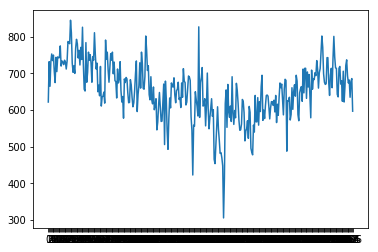

In [20]:
plt.plot(crimes_date.index,crimes_date.crimes_count_date)

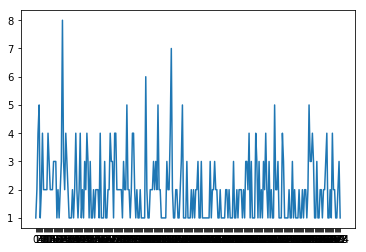

In [81]:
plt.plot(homicides_date.index,homicides_date.homicides_count_date)

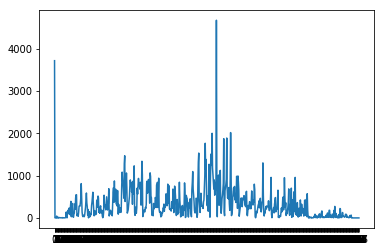

In [21]:
plt.plot(crimes_loc.index,crimes_loc.crimes_count_loc)

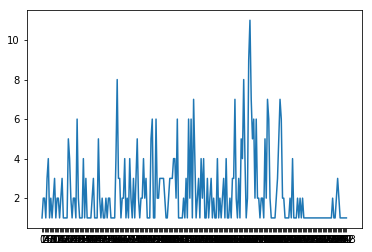

In [82]:
plt.plot(homicides_loc.index,homicides_loc.homicides_count_loc)

## Calculating distances between Airbnb listings and criminal occurrences

We're interested in knowing the criminal activity surrounding each Airbnb listing. To do that, we'll calculate the distance between each unique location on our listings database and each unique location on our criminal occurrence database.

In [0]:
def distance(a,b):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees). Output in KM
    """
    lat1 = a[0]
    lat2 = b[0]
    lon1 = a[1]
    lon2 = b[1]
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

In [0]:
distances=[None]*len(list_locs)
for i in range(len(list_locs)):
  a=[None]*len(crim_locs)
  x=list_locs[i]
  for j in range(len(crim_locs)):
    a[j]=round(distance(x,crim_locs[j]),2)
  distances[i]=a
  
dist_df=pd.DataFrame(distances)

In [0]:
#dist_df.head(10)

In [0]:
dist1_df=dist_df[dist_df<=1].notnull().astype('int')
dist1_df=dist1_df.fillna(0)
#dist1_df.head()

In [0]:
dist2_df=dist_df[dist_df<=2].notnull().astype('int')
dist2_df=dist2_df.fillna(0)
#dist2_df.head()

In [0]:
dist5_df=dist_df[dist_df<=5].notnull().astype('int')
dist5_df=dist5_df.fillna(0)
#dist5_df.head()

#Creating our full Airbnb database

In [0]:
airbnb=calendar.merge(listings,on=['listing_id'],how='inner')
#airbnb.head()

In [0]:
airbnb_c=airbnb.merge(crimes_date,on=['date'])
airbnb_c['loc_id'] = airbnb_c.loc_id2
airbnb_c['crim_loc_id'] = airbnb_c.crim_loc_id2
airbnb_c = airbnb_c.drop(columns=['loc_id2','crim_loc_id2'])
airbnb_c = airbnb_c.assign(date_id=(airbnb_c['date'].astype('category').cat.codes))
airbnb_c = airbnb_c.rename(index=str, columns={"crim_loc_id": "crimes_that_date"})
airbnb_c = airbnb_c.sort_values(by=['listing_id','date'])
#airbnb_c.head()

In [0]:
airbnb_cr=airbnb_c[airbnb_c.review==1]
airbnb_cr=airbnb_cr.drop(columns=['review'])
#airbnb_cr

In [0]:
def indices(lst, element):
    result = []
    offset = -1
    while True:
        try:
            offset = lst.index(element, offset+1)
        except ValueError:
            return result
        result.append(offset)

In [0]:
airbnb_cr['crimes_loc_1km']=np.nan
airbnb_cr['crimes_loc_2km']=np.nan
airbnb_cr['crimes_loc_5km']=np.nan

crimes_loc_1km=[None]*len(airbnb_cr)
crimes_loc_2km=[None]*len(airbnb_cr)
crimes_loc_5km=[None]*len(airbnb_cr)

for i in range(len(airbnb_cr)):
  loc_id=airbnb_cr.loc_id.iloc[i]
  crimes_loc_1km[i]=indices(list(dist1_df.iloc[loc_id]),1)
  crimes_loc_2km[i]=list(np.setdiff1d(indices(list(dist2_df.loc[loc_id]),1),indices(list(dist1_df.loc[loc_id]),1)))
  crimes_loc_5km[i]=list(np.setdiff1d(indices(list(dist5_df.loc[loc_id]),1),indices(list(dist2_df.loc[loc_id]),1)))

airbnb_cr.crimes_loc_1km=crimes_loc_1km
airbnb_cr.crimes_loc_2km=crimes_loc_2km
airbnb_cr.crimes_loc_5km=crimes_loc_5km

#airbnb_cr.head()

In [0]:
airbnb_cr['crimes_1km']=np.nan
airbnb_cr['crimes_2km']=np.nan
airbnb_cr['crimes_5km']=np.nan

crimes_1km=[None]*len(airbnb_cr)
crimes_2km=[None]*len(airbnb_cr)
crimes_5km=[None]*len(airbnb_cr)

for i in range(len(airbnb_cr)):
  crimes_that_date = airbnb_cr.crimes_that_date.iloc[i]
  crimes_1km[i] = list(set(crimes_that_date).intersection(airbnb_cr.crimes_loc_1km.iloc[i]))
  crimes_2km[i] = list(set(crimes_that_date).intersection(airbnb_cr.crimes_loc_2km.iloc[i]))
  crimes_5km[i] = list(set(crimes_that_date).intersection(airbnb_cr.crimes_loc_5km.iloc[i]))
  
airbnb_cr.crimes_1km=crimes_1km
airbnb_cr.crimes_2km=crimes_2km
airbnb_cr.crimes_5km=crimes_5km

#airbnb_cr.head()

In [39]:
#airbnb_cr.head()

,listing_id,date,price,month,day,year,host_id,neighbourhood,room_type,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,lr_m,lr_d,lr_y,lat,lon,location,loc,loc_id,crimes_that_date,crimes_count_date,date_id,crimes_loc_1km,crimes_loc_2km,crimes_loc_5km,crimes_1km,crimes_2km,crimes_5km
38834,2384,2018-07-26,75.0,7,26,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,"[0, 33, 34, 35, 37, 40, 45, 49, 50, 51, 56, 58...",731,17,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...","[244, 246]","[224, 225, 264, 265, 266, 633, 223]","[262, 263, 279, 281, 162, 163, 164, 165, 166, ..."
47199,2384,2018-07-29,69.0,7,29,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,"[0, 36, 37, 38, 40, 41, 42, 46, 47, 48, 49, 50...",731,20,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...",[],"[224, 225, 265, 266, 267, 243, 223]","[262, 263, 278, 279, 280, 281, 289, 162, 163, ..."
64461,2384,2018-08-05,65.0,8,5,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,"[0, 32, 33, 36, 37, 43, 45, 47, 50, 51, 52, 57...",811,27,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...",[246],"[265, 266, 267, 243, 223]","[262, 263, 280, 281, 289, 162, 163, 164, 165, ..."
85514,2384,2018-08-12,75.0,8,12,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,"[0, 27, 30, 31, 34, 36, 37, 40, 41, 46, 47, 48...",781,34,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...","[244, 246]","[224, 225, 265, 266, 267, 223]","[263, 278, 279, 289, 162, 163, 164, 165, 166, ..."
177947,2384,2018-10-01,65.0,10,1,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,"[0, 32, 34, 36, 37, 41, 47, 50, 54, 56, 58, 60...",732,84,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...",[244],"[224, 264, 265, 266, 223]","[263, 279, 280, 281, 289, 162, 163, 164, 165, ..."


In [40]:
airbnb_cr['crimes_1km_count']=np.nan
airbnb_cr['crimes_2km_count']=np.nan
airbnb_cr['crimes_5km_count']=np.nan

crimes_1km_count=[None]*len(airbnb_cr)
crimes_2km_count=[None]*len(airbnb_cr)
crimes_5km_count=[None]*len(airbnb_cr)

for i in range(len(airbnb_cr)):
  c=crimes[crimes["date"]==airbnb_cr.date.iloc[i]]
  l1=airbnb_cr.crimes_1km.iloc[i]
  l2=airbnb_cr.crimes_2km.iloc[i]
  l5=airbnb_cr.crimes_5km.iloc[i]
  
  c1=c[c["crim_loc_id2"].isin(l1)]
  c2=c[c["crim_loc_id2"].isin(l2)]
  c5=c[c["crim_loc_id2"].isin(l5)]  
  
  crimes_1km_count[i]=len(c1)
  crimes_2km_count[i]=len(c2)
  crimes_5km_count[i]=len(c5)  
  
airbnb_cr.crimes_1km_count=crimes_1km_count
airbnb_cr.crimes_2km_count=crimes_2km_count
airbnb_cr.crimes_5km_count=crimes_5km_count

#airbnb_cr.head()

,listing_id,date,price,month,day,year,host_id,neighbourhood,room_type,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,lr_m,lr_d,lr_y,lat,lon,location,loc,loc_id,crimes_that_date,crimes_count_date,date_id,crimes_loc_1km,crimes_loc_2km,crimes_loc_5km,crimes_1km,crimes_2km,crimes_5km,crimes_1km_count,crimes_2km_count,crimes_5km_count
38834,2384,2018-07-26,75.0,7,26,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,"[0, 33, 34, 35, 37, 40, 45, 49, 50, 51, 56, 58...",731,17,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...","[244, 246]","[224, 225, 264, 265, 266, 633, 223]","[262, 263, 279, 281, 162, 163, 164, 165, 166, ...",4,14,89
47199,2384,2018-07-29,69.0,7,29,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,"[0, 36, 37, 38, 40, 41, 42, 46, 47, 48, 49, 50...",731,20,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...",[],"[224, 225, 265, 266, 267, 243, 223]","[262, 263, 278, 279, 280, 281, 289, 162, 163, ...",0,20,76
64461,2384,2018-08-05,65.0,8,5,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,"[0, 32, 33, 36, 37, 43, 45, 47, 50, 51, 52, 57...",811,27,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...",[246],"[265, 266, 267, 243, 223]","[262, 263, 280, 281, 289, 162, 163, 164, 165, ...",1,12,94
85514,2384,2018-08-12,75.0,8,12,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,"[0, 27, 30, 31, 34, 36, 37, 40, 41, 46, 47, 48...",781,34,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...","[244, 246]","[224, 225, 265, 266, 267, 223]","[263, 278, 279, 289, 162, 163, 164, 165, 166, ...",3,14,84
177947,2384,2018-10-01,65.0,10,1,2018,2613,Hyde Park,2,159,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",71,"[0, 32, 34, 36, 37, 41, 47, 50, 54, 56, 58, 60...",732,84,"[244, 245, 246]","[223, 224, 225, 243, 264, 265, 266, 267, 632, ...","[162, 163, 164, 165, 166, 178, 179, 180, 181, ...",[244],"[224, 264, 265, 266, 223]","[263, 279, 280, 281, 289, 162, 163, 164, 165, ...",1,7,86


In [69]:
from sklearn.linear_model import LinearRegression
#X = airbnb_cr[['crimes_1km_count','crimes_2km_count','crimes_5km_count','crimes_count_date','availability_365','number_of_reviews','room_type','neighbourhood']]
X = airbnb_cr[['crimes_1km_count','crimes_2km_count','crimes_5km_count','crimes_count_date']]
X.crimes_1km_count=X.crimes_1km_count/X.crimes_count_date
X.crimes_2km_count=X.crimes_2km_count/X.crimes_count_date
X.crimes_5km_count=X.crimes_5km_count/X.crimes_count_date
X = X[['crimes_1km_count','crimes_2km_count','crimes_5km_count']]
# = airbnb_cr[['price']]

#X = pd.concat([X.drop('room_type', axis=1), pd.get_dummies(X.room_type, prefix='room_type', drop_first=True)], axis=1)
#X = pd.concat([X.drop('neighbourhood', axis=1), pd.get_dummies(X.neighbourhood, drop_first=True)], axis=1)
X.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,crimes_1km_count,crimes_2km_count,crimes_5km_count
38834,0.005472,0.019152,0.121751
47199,0.000000,0.027360,0.103967
64461,0.001233,0.014797,0.115906
85514,0.003841,0.017926,0.107554
177947,0.001366,0.009563,0.117486


In [66]:
#Z=airbnb_cr[['crimes_1km_count','price']]
#Z.corr()

,crimes_1km_count,price
crimes_1km_count,1.000000,0.151853
price,0.151853,1.000000


In [70]:
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)
print(reg.intercept_)
#reg.predict(np.array([[3, 5]]))


0.022426567480128057
[[1307.60267408  744.837853    -31.29835387]]
[94.97011164]


In [0]:
#list_mean_m = airbnb_cr.groupby(['listing_id','year','month']).mean()
#list_sum_m = airbnb_cr.groupby(['listing_id','year','month']).sum()
#list_count_m = airbnb_cr.groupby(['listing_id','year','month']).count()

#list_mean_y = airbnb_cr.groupby(['listing_id','year']).mean()
#list_sum_y = airbnb_cr.groupby(['listing_id','year']).sum()
#list_count_y = airbnb_cr.groupby(['listing_id','year']).count()

#list_mean = airbnb_cr.groupby(['listing_id']).mean()
#list_sum = airbnb_cr.groupby(['listing_id']).sum()
#list_count = airbnb_cr.groupby(['listing_id']).count()

In [0]:
#neigh_mean_y = airbnb_cr.groupby(['neighbourhood','year']).mean()
#neigh_sum_y = airbnb_cr.groupby(['neighbourhood','year']).sum()
#neigh_count_y = airbnb_cr.groupby(['neighbourhood','year']).count()

#neigh_mean_m = airbnb_cr.groupby(['neighbourhood','year','month']).mean()
#neigh_sum_m = airbnb_cr.groupby(['neighbourhood','year','month']).sum()
#neigh_count_m = airbnb_cr.groupby(['neighbourhood','year','month']).count()

#neigh_mean = airbnb_cr.groupby(['neighbourhood']).mean()
#neigh_sum = airbnb_cr.groupby(['neighbourhood']).sum()
#neigh_count = airbnb_cr.groupby(['neighbourhood']).count()

In [0]:
#loc_id_mean_y = airbnb_cr.groupby(['loc_id','year']).mean()
#loc_id_sum_y = airbnb_cr.groupby(['loc_id','year']).sum()
#loc_id_count_y = airbnb_cr.groupby(['loc_id','year']).count()

#loc_id_mean_m = airbnb_cr.groupby(['loc_id','year','month']).mean()
#loc_id_sum_m = airbnb_cr.groupby(['loc_id','year','month']).sum()
#loc_id_count_m = airbnb_cr.groupby(['loc_id','year','month']).count()

#loc_id_mean = airbnb_cr.groupby(['loc_id']).mean()
#loc_id_sum = airbnb_cr.groupby(['loc_id']).sum()
#loc_id_count = airbnb_cr.groupby(['loc_id']).count()

In [0]:
#room_type_mean_y = airbnb_cr.groupby(['room_type','year']).mean()
#room_type_sum_y = airbnb_cr.groupby(['room_type','year']).sum()
#room_type_count_y = airbnb_cr.groupby(['room_type','year']).count()

#room_type_mean_m = airbnb_cr.groupby(['room_type','year','month']).mean()
#room_type_sum_m = airbnb_cr.groupby(['room_type','year','month']).sum()
#room_type_count_m = airbnb_cr.groupby(['room_type','year','month']).count()

#room_type_mean = airbnb_cr.groupby(['room_type']).mean()
#room_type_sum = airbnb_cr.groupby(['room_type']).sum()
#room_type_count = airbnb_cr.groupby(['room_type']).count()

In [0]:
#mean_y = airbnb_cr.groupby(['year']).mean()
#sum_y = airbnb_cr.groupby(['year']).sum()
#count_y = airbnb_cr.groupby(['year']).count()

#mean_m = airbnb_cr.groupby(['year','month']).mean()
#sum_m = airbnb_cr.groupby(['year','month']).sum()
#count_m = airbnb_cr.groupby(['year','month']).count()

In [85]:
p = figure(x_axis_type='mercator',y_axis_type='mercator')
p.add_tile(CARTODBPOSITRON)
p.circle(x=listings['lat'],y=listings['lon'])
output_notebook()
show(p)